In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
def load_data(file_name):
    # loading data set
    dataset = pd.read_excel(io=file_name)
    
    from pandas.tseries.offsets import MonthEnd
    
    # reassigning date and month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # sorting data with date 
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # deleting unrequired colums
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index of data 
    dataset.set_index('Date', inplace=True)
    
    # drop Null records
    dataset.dropna(subset=['Combined'], inplace=True)
    
    return dataset

df = load_data(file_name="montly.xlsx")
df.tail()



,Combined
Date,
2023-09-30,5.02
2023-10-31,4.87
2023-11-30,5.55
2023-12-31,5.69
2024-01-31,5.10


<class 'pandas.core.series.Series'>
DatetimeIndex: 121 entries, 2014-01-31 to 2024-01-31
Series name: Combined
Non-Null Count  Dtype  
--------------  -----  
121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


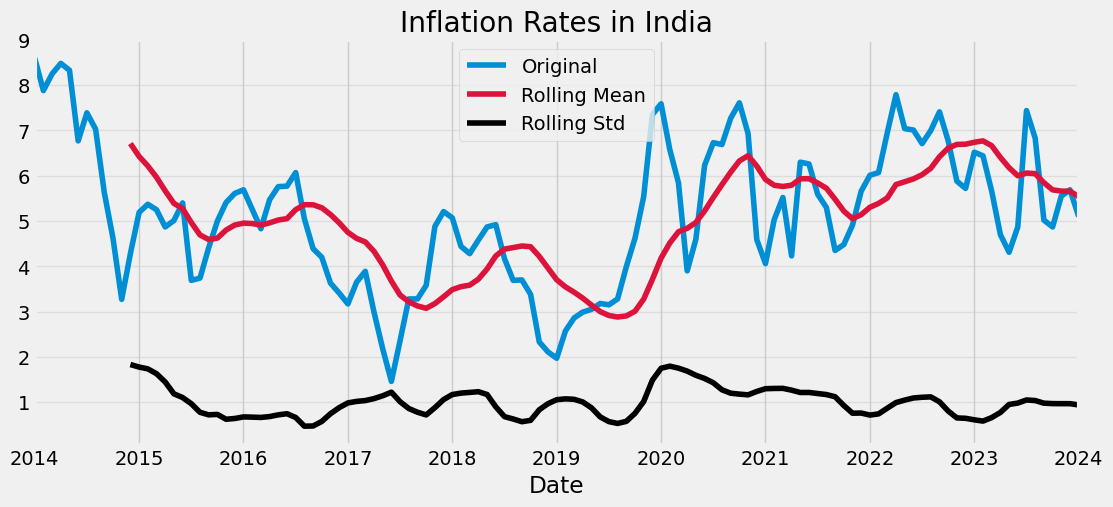

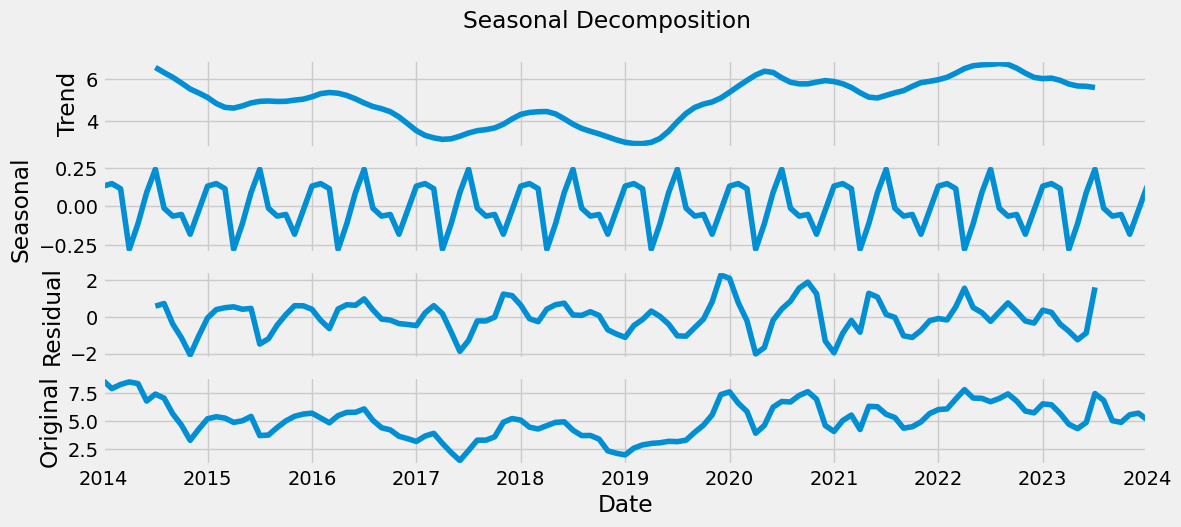

In [3]:
def plot_time_series(series):
    
    
    # Converting index to DatetimeIndex just be ensured
    if not isinstance(series.index, pd.DatetimeIndex):
        # Assuming the index is a datetime-like object, you can convert it
        series.index = pd.to_datetime(series.index)
    
    series.info()
    
    # frequency is set 
    series = series.asfreq('M')

    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()

    # Plot inflation rates with its rolling mean and standard deviation 
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Inflation Rate in India')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

    # Seasonal decomposition of data which gives inghts on the data patterns (Treands and seasonal patterns)
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')

    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')

    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')

    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')

    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

# Passing  the df data set
plot_time_series(df['Combined'])

In [4]:
def adf_test(series):
    
    # Adfuller test is one of the common test to know if time data exibites null hypothies

    result = adfuller(series, regression='c', autolag='AIC')
    print('========= Augmented Dickey-Fuller Test =========\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\n Strong evidence against the null hypothesis (H0),  Data is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, it is non stationay series.')
    return


adf_test(df['Combined'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -2.021724
2. P-value: 0.277130
3. Used Lags: 12
4. Used Observations: 108
5. Critical Values:
	1%: -3.492401
	5%: -2.888697
	10%: -2.581255

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [5]:
# After ADF test data is trannsformed to minimize the p value 

def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed ')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot- autocorrelation plot (ACF)
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation (ACF)')
    # plot with 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot- partial autocorrelation plot (PACF)
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title='Partial Autocorrelation (PCAF)')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return


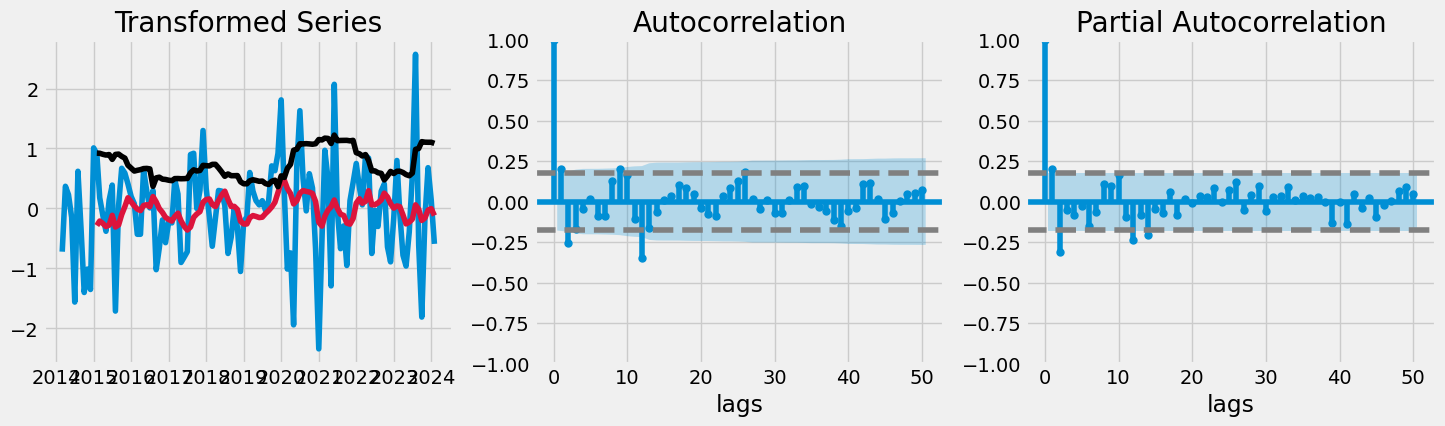

P-value = 0.000140, the series is likely stationary.


In [6]:
# We can also apply difference on data with applying log or squar root
series_transformation(df.diff())

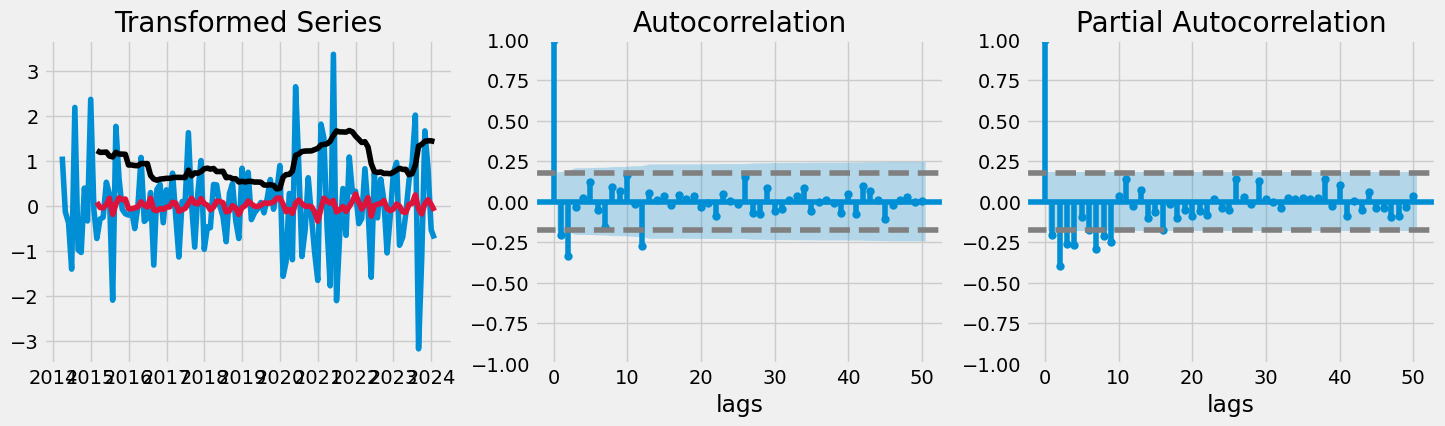

P-value = 0.000790, the series is likely stationary.


In [7]:
# second Square root difference
series_transformation(df.diff().diff())

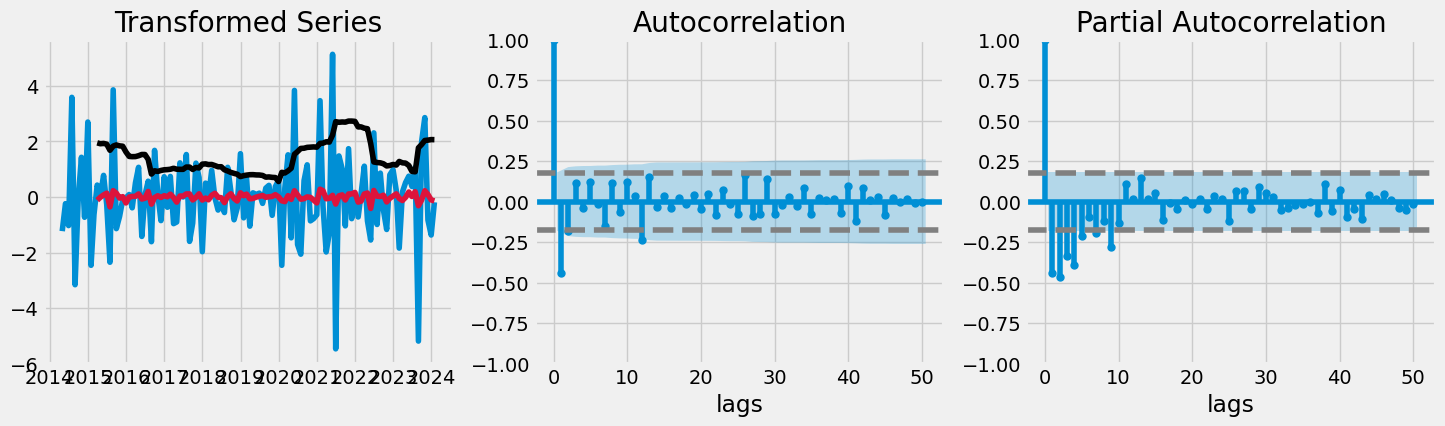

P-value = 0.000000, the series is likely stationary.


In [8]:
# third difference
series_transformation(df.diff().diff().diff())

In [9]:
# finding best orders for SARIMAX model by iterating each combination in for loop

def find_optimal_orders(series, verbose=True):

    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import time
    

    start_time = time.time()
    
    # For loop with possible combination
    order_list = []
    for p in range(0, 3):
            for d in range(0, 2):
                for q in range(0, 3):
                    order_list.append((p, d, q))
    
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    # loop through every possible combination and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(trend_pdq)))
    print('================= SARIMAX Results =================\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal, freq='M', exog=None,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except:
                print('Error while fitting model')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    

    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff%3600//60, diff%60))

In [10]:
# Main function calling
find_optimal_orders(df['Combined'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 743.887644,	BIC = 746.675136
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 601.144062,	BIC = 606.508325
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 493.729037,	BIC = 501.422082
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 477.399077,	BIC = 480.081208
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 382.781589,	BIC = 387.910285
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 333.828344,	BIC = 341.120794
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 476.037595,	BIC = 481.420291
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 439.968100,	BIC = 448.014494
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 366.280117,	BIC = 376.537509
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 369.873080,	BIC = 375.022502
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 366.282516,	BIC = 373.975560
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 319.340041,	BIC = 329.063309
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 371.695393,	BIC = 379.419526
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 

119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 236.167699,	BIC = 246.425092
120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 211.719145,	BIC = 223.873229
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 216.087554,	BIC = 226.344947
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 218.004923,	BIC = 230.826664
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 220.547153,	BIC = 235.933242
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 222.054167,	BIC = 231.777434
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 214.752547,	BIC = 226.906631
126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 213.444056,	BIC = 228.028957
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 274.162924,	BIC = 282.500294
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 233.534600,	BIC = 244.225915
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 215.822104,	BIC = 228.591489
130. SARIMAX(1, 0, 1)(0, 1, 0)[12],	AIC = 333.051887,	BIC = 341.070373
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 228.565733,	BIC = 238.781240
132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 203.911916,	BIC = 216.006119
133. S

237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 215.687456,	BIC = 231.010718
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 334.994785,	BIC = 345.686100
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 230.453260,	BIC = 243.222645
240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 204.742992,	BIC = 219.256035
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 228.800368,	BIC = 242.164513
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 230.693125,	BIC = 246.730098
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 213.923366,	BIC = 231.800504
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 248.282471,	BIC = 261.051856
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 227.397593,	BIC = 242.720855
246. SARIMAX(2, 0, 1)(1, 1, 2)[12],	AIC = 204.528945,	BIC = 221.460829
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 211.787102,	BIC = 227.110363
248. SARIMAX(2, 0, 1)(2, 0, 1)[12],	AIC = 213.779593,	BIC = 231.656731
249. SARIMAX(2, 0, 1)(2, 0, 2)[12],	AIC = 215.715306,	BIC = 236.146321
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 214.043487,	BIC = 228.556531
251. S

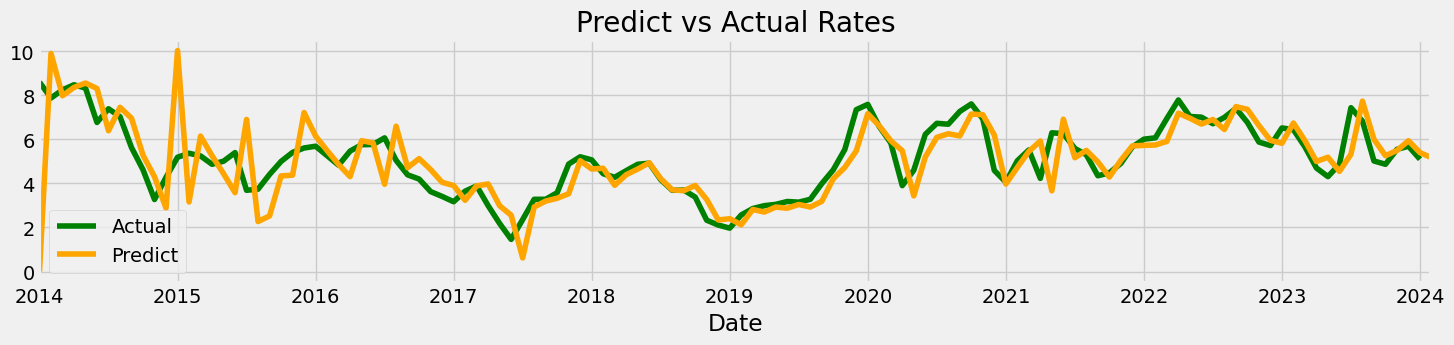

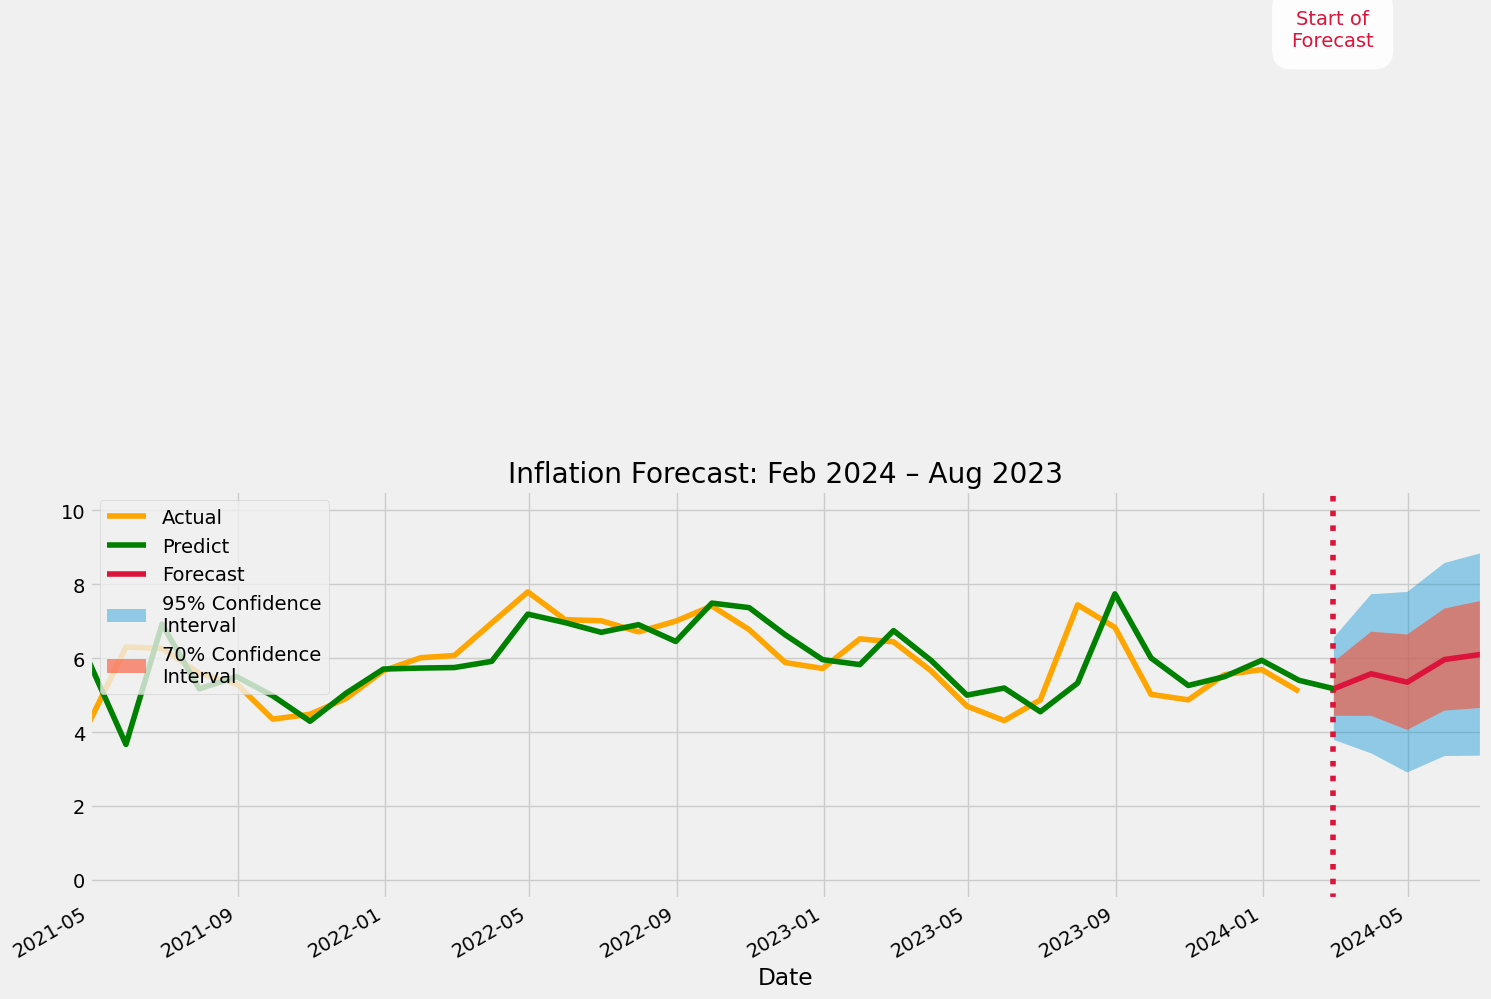

,Forecast [%]
2024-02-29,5.2
2024-03-31,5.6
2024-04-30,5.3
2024-05-31,6.0
2024-06-30,6.1
2024-07-31,5.2


In [14]:
# SARIMA model visualization
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    

    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions (from February 2024)
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')

    # forecast and confidence intervals 70% and 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # index list
    def index_list():
        conf_interval = conf_int_95.reset_index()
        return conf_interval['index'].to_list()

    indx_list = index_list()
    
    # actual vs predict rates plot
    series.plot(legend=True, label='Actual', figsize=(16, 3), color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Predict vs Actual Rates')
    plt.legend()
    plt.show()
    
    # list of events to plot
    event_list = [(pd.to_datetime('2024-02-28'), 'Start of\nForecast', 'crimson')]
    
    # event ploting
    for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=23, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))

    # forecasting focused plot
    series.plot(legend=True, label='Actual', figsize=(16,6), color='orange')
    yhat.plot(legend=True, color='green')
    conf_int_95['mean'].plot(legend=True, label='Forecast', color='crimson')
    # confidence intervals with 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'], y2=conf_int_95['mean_ci_lower'],
                     alpha=0.4, label='95% Confidence\nInterval', linewidth=0)
    # confidence intervals with 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'], y2=conf_int_70['mean_ci_lower'],
                     alpha=0.6, label='70% Confidence\nInterval', linewidth=0)
    plt.xlim(['2021-05', '2024-07'])
    plt.title('Inflation Forecast: Feb 2024 – Aug 2024')
    plt.legend(loc='upper left')
    plt.show()
    

    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Forecast [%]'}, axis=1)

# Final Forcasting Function
forecast_SARIMA(series=df['Combined'], order=(1, 1, 2), seasonal_order=(0, 1, 2, 12))

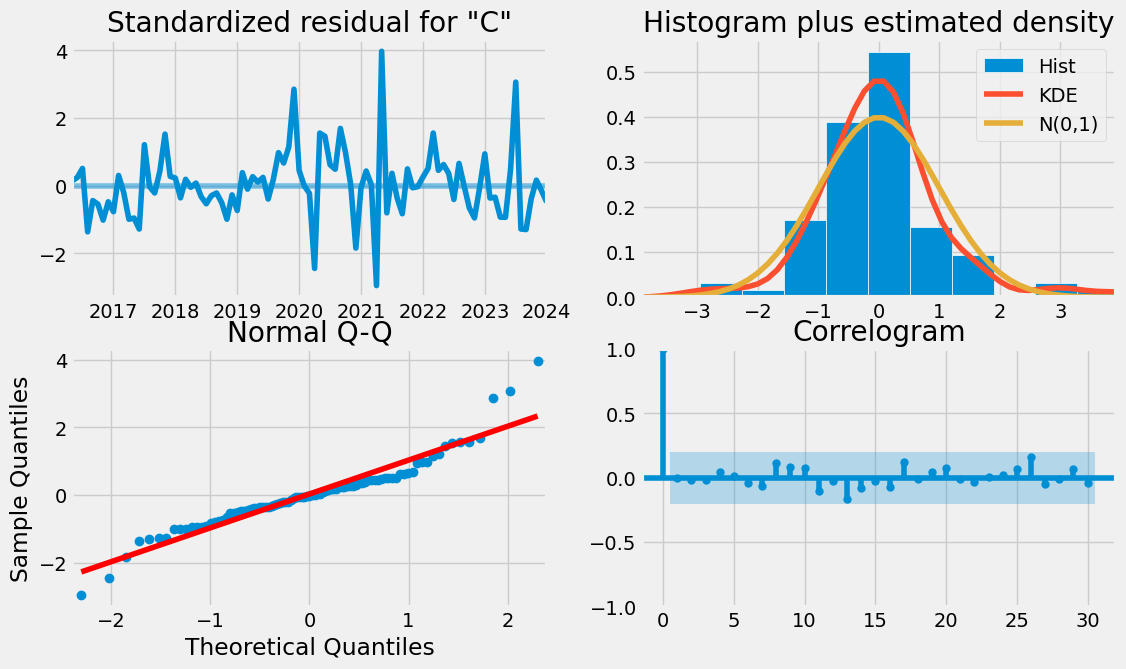

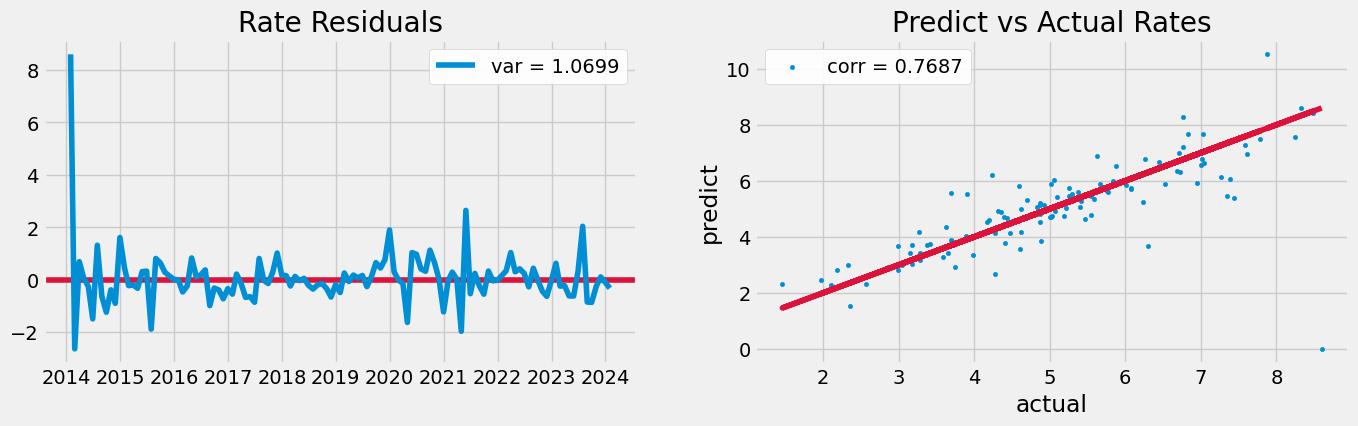

Metric,AIC,BIC,HQIC,RMSE,MAE,MAPE
,202.425076,217.620673,208.560623,1.071461,0.581646,0.117393


In [12]:
# model evaluation
def evaluate_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX


    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=None,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False)
    
    # evaluation scores
    rmse = np.mean((series - yhat[:-1])**2)**0.5
    mae = np.mean(np.abs(series - yhat[:-1]))
    mape = np.mean(np.abs(series - yhat[:-1])/np.abs(series))
    var = np.std(model_fit.resid.values)
    corr = np.corrcoef(series, yhat[:-1])[0, 1]
    
    metric_list = ['AIC', 'BIC', 'HQIC', 'RMSE', 'MAE', 'MAPE']
    value_list = [model_fit.aic, model_fit.bic, model_fit.hqic, rmse, mae, mape]
 
    # 1st plot- diagnostics
    model_fit.plot_diagnostics(lags=30, figsize=(12, 7))
    plt.show()
    
    # 2nd plot- residuals
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.axhline(0, color='crimson')
    plt.plot(model_fit.resid, label='var = {:.4f}'.format(var))
    plt.title('Rate Residuals')
    plt.legend(facecolor='white', framealpha=0.9)
    
    # 3rd plot - actual vs predict rates
    plt.subplot(1, 2, 2)
    plt.plot(df['Combined'], df['Combined'], color='crimson')
    plt.scatter(x=df['Combined'], y=yhat[:-1], marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predict vs Actual Rates')
    plt.xlabel('actual')
    plt.ylabel('predict')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()

    # display evaluation scores
    return pd.DataFrame(zip(metric_list, value_list), columns=['Metric', '']).set_index('Metric').T

evaluate_SARIMA(series=df['Combined'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))